In [1]:
from datetime import datetime, timezone, timedelta
from argopy import DataFetcher, ArgoNVSReferenceTables, ArgoIndex
import argopy, os, pytz
from sqlalchemy import create_engine, and_, func, UniqueConstraint, select, update, delete
from geoalchemy2 import Geometry
from sqlalchemy.orm import declarative_base, sessionmaker, scoped_session, relationship
from sqlalchemy.orm.exc import NoResultFound
from sqlalchemy.pool import NullPool
from sqlalchemy.dialects.postgresql import insert, JSONB
from sqlalchemy import Index, Column, Integer, Float, DateTime, String, TEXT, TIMESTAMP, inspect, ForeignKey, JSON
from geoalchemy2 import WKTElement, Geometry
from geoalchemy2.shape import from_shape
from shapely.geometry import LineString
import pandas as pd
import numpy as np
import geojson
from argopy.plot import scatter_map, scatter_plot #only needed to plot  

In [2]:
argopy.show_versions()


SYSTEM
------
commit: None
python: 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
python-bits: 64
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
byteorder: little
LC_ALL: None
LANG: None
LOCALE: Chinese (Traditional)_Taiwan.950
libhdf5: 1.14.4
libnetcdf: 4.9.2

INSTALLED VERSIONS: CORE
------------------------
aiohttp     : 3.11.10     
argopy      : 1.0.0       
decorator   : 5.1.1       
erddapy     : 2.2.3       
fsspec      : 2024.10.0   
netCDF4     : 1.7.2       
packaging   : 23.2        
requests    : 2.32.3      
scipy       : 1.14.1      
toolz       : 1.0.0       
xarray      : 2024.2.0    

INSTALLED VERSIONS: EXT.UTIL
----------------------------
boto3       : -           
gsw         : -           
s3fs        : -           
tqdm        : -           
zarr        : -           

INSTALLED VERSIONS: EXT.PERF
----------------------------
dask        : -           
distributed : -    

In [2]:
# Get the directory of your current script
current_dir = os.path.abspath(os.path.dirname("__file__"))

# Define the path to the tmp_cache directory relative to your current script
cache_dir = os.path.join(current_dir, '..', 'tmp_cache')
print(cache_dir)

# Create the cache directory if it doesn't exist
os.makedirs(cache_dir, exist_ok=True)

# Set argopy options with the correct path
argopy.set_options(cachedir=cache_dir)


d:\proj\argo\dev\..\tmp_cache


In [3]:
import os
from urllib.parse import quote 
from dotenv import load_dotenv

load_dotenv()
DBUSER = os.getenv('DBUSER')
DBPASS = os.getenv('DBPASS')
DBHOST = os.getenv('DBHOST')
DBPORT = os.getenv('DBPORT')
DBNAME = os.getenv('DBNAME')
WMOTABLE = os.getenv('WMOTABLE')
ARGOTABLE = os.getenv('ARGOTABLE')
TRAJTABLE = os.getenv('TRAJTABLE')

In [4]:
# Connect to the PostGIS database
conn_uri = 'postgresql://' + DBUSER + ':%s@' + DBHOST + ':' + DBPORT + '/' + DBNAME

# Create the SQLAlchemy engine with increased timeout and connection pooling
engine = create_engine(
    conn_uri % quote(DBPASS),
    connect_args={'connect_timeout': 10},  # Set a higher timeout
    pool_pre_ping=True,  # Enable pre-pinging to avoid broken connections
    poolclass=NullPool    # Optional: Use NullPool if you want to avoid pooling, or adjust as needed
)

In [4]:
reftbl = ArgoNVSReferenceTables().tbl('R03')
oceantbl = ArgoNVSReferenceTables().tbl('R13')

In [5]:
test_profiler = ArgoNVSReferenceTables().tbl('R08')
print(test_profiler)

   altLabel                                          prefLabel  \
0       890                            PROVOR_III - Jumbo, SBE   
1       891                            PROVOR_III - Jumbo, RBR   
2       841          PROVOR float with SBE conductivity sensor   
3       838    ARVOR-D deep float with SBE conductivity sensor   
4       831                                       PALACE float   
5       889                              PROVOR_V - Jumbo, RBR   
6       875            ALTO float with RBR conductivity sensor   
7       877            APEX float with RBR conductivity sensor   
8       881                                             HM4000   
9       851            SOLO float with SBE conductivity sensor   
10      847  Teledyne Webb Research float with FSI conducti...   
11      848         APEX-EM float with SBE conductivity sensor   
12      835                                          PROVOR IV   
13      837         ARVOR-C float with SBE conductivity sensor   
14      87

In [5]:
# Replace problematic values with NaN and then drop them
test_profiler['altLabel'] = pd.to_numeric(test_profiler['altLabel'], errors='coerce')

# Drop rows with NaN in the `altLabel` column
test_profiler = test_profiler.dropna(subset=['altLabel'])

# Convert to integers
test_profiler['altLabel'] = test_profiler['altLabel'].astype(int)

C:\Users\user\AppData\Local\Temp\ipykernel_19420\4063947045.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_profiler['altLabel'] = test_profiler['altLabel'].astype(int)


In [17]:
test1 = test_profiler[test_profiler['altLabel'].isin(range(830, 847))]
print(test1)

Empty DataFrame
Columns: [altLabel, prefLabel, definition, deprecated, id]
Index: []


In [6]:
param_list = reftbl['altLabel'].tolist()
print(param_list)

['NB_SAMPLE_MCOMS', 'NB_SAMPLE_OPTODE', 'CHLA_FLUORESCENCE', 'NB_SAMPLE_SUNA', 'NB_SAMPLE_CYC', 'NB_SAMPLE_DURAFET', 'NB_SAMPLE_CTD', 'NB_SAMPLE_OCR', 'NB_SAMPLE_STM', 'NB_SAMPLE_ECO', 'NB_SAMPLE_CROVER', 'NB_SAMPLE_ISUS', 'TEMP_CNDC', 'PH_IN_SITU_FREE', 'PH_IN_SITU_TOTAL', 'PH_IN_SITU_SEAWATER', 'DOWNWELLING_PAR', 'TEMP_VOLTAGE_DOXY', 'VRS_PH', 'VK_PH', 'VOLTAGE_DOXY', 'IK_PH', 'IB_PH', 'PHASE_DELAY_DOXY', 'PPOX_DOXY', 'PRES', 'CNDC', 'MTIME', 'CP660', 'CP', 'UP_RADIANCE555', 'UP_RADIANCE', 'UP_RADIANCE443', 'UP_RADIANCE412', 'UP_RADIANCE490', 'CDOM', 'DOWN_IRRADIANCE', 'DOWN_IRRADIANCE412', 'DOWN_IRRADIANCE490', 'DOWN_IRRADIANCE443', 'DOWN_IRRADIANCE380', 'DOWN_IRRADIANCE555', 'FREQUENCY_DOXY', 'BBP700', 'BBP', 'BBP532', 'BBP470', 'TEMP_SPECTROPHOTOMETER_NITRATE', 'TEMP_DOXY', 'TEMP_PH', 'TEMP_NITRATE', 'HUMIDITY_NITRATE', 'C1PHASE_DOXY', 'TPHASE_DOXY', 'TILT', 'C2PHASE_DOXY', 'RPHASE_DOXY', 'BPHASE_DOXY', 'DPHASE_DOXY', 'MOLAR_DOXY', 'MOLAR_NITRATE', 'BETA_BACKSCATTERING700', 'BETA_

In [7]:
print(oceantbl)

  altLabel            prefLabel  \
0        I    Indian ocean area   
1        A  Atlantic ocean area   
2        P   Pacific ocean area   

                                          definition deprecated  \
0  Below 30 degrees south, the Indian/Atlantic oc...      false   
1  Below 30 degrees south, the Atlantic/Pacific o...      false   
2  Below 30 degrees south, the Pacific/Indian oce...      false   

                                                  id  
0  http://vocab.nerc.ac.uk/collection/R13/current/I/  
1  http://vocab.nerc.ac.uk/collection/R13/current/A/  
2  http://vocab.nerc.ac.uk/collection/R13/current/P/  


In [8]:
sidx = ArgoIndex(index_file='bgc-s').load() 
sidx

<argoindex.pandas>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt.gz
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
In memory: True (330710 records)
Searched: False

In [49]:
dfs = sidx.to_dataframe()
dfs

,file,date,latitude,longitude,ocean,profiler_code,institution_code,parameters,parameter_data_mode,date_update,wmo,cyc,institution,dac,profiler
0,aoml/1900722/profiles/SD1900722_001.nc,2006-10-22 02:16:24,-40.316,73.389,I,846,AO,PRES TEMP PSAL DOXY,DDDD,2022-06-28 08:08:01,1900722,1,"AOML, USA",aoml,Unknown
1,aoml/1900722/profiles/SD1900722_002.nc,2006-11-01 06:44:23,-40.390,73.528,I,846,AO,PRES TEMP PSAL DOXY,DDDD,2022-06-28 08:08:13,1900722,2,"AOML, USA",aoml,Unknown
2,aoml/1900722/profiles/SD1900722_003.nc,2006-11-11 10:12:22,-40.455,73.335,I,846,AO,PRES TEMP PSAL DOXY,DDDD,2022-06-28 08:08:26,1900722,3,"AOML, USA",aoml,Unknown
3,aoml/1900722/profiles/SD1900722_004.nc,2006-11-21 07:50:21,-40.134,73.080,I,846,AO,PRES TEMP PSAL DOXY,DDDD,2022-06-28 08:08:39,1900722,4,"AOML, USA",aoml,Unknown
4,aoml/1900722/profiles/SD1900722_005.nc,2006-12-01 18:33:00,-39.641,73.158,I,846,AO,PRES TEMP PSAL DOXY,DDDD,2022-06-28 08:08:52,1900722,5,"AOML, USA",aoml,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330705,meds/4902688/profiles/SR4902688_048.nc,2024-11-11 15:35:00,58.448,-52.114,A,834,ME,PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...,RRRRRRRRAR,2024-11-12 00:52:04,4902688,48,"MEDS, Canada",meds,Unknown
330706,meds/4902688/profiles/SR4902688_049.nc,2024-11-17 15:33:00,58.378,-52.044,A,834,ME,PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...,RRRRRRRRAR,2024-11-18 01:08:12,4902688,49,"MEDS, Canada",meds,Unknown
330707,meds/4902688/profiles/SR4902688_050.nc,2024-11-23 15:37:00,58.430,-53.097,A,834,ME,PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...,RRRRRRRRAR,2024-11-24 00:57:03,4902688,50,"MEDS, Canada",meds,Unknown
330708,meds/4902688/profiles/SR4902688_051.nc,2024-11-29 15:33:00,58.487,-53.154,A,834,ME,PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...,RRRRRRRRAR,2024-11-30 00:53:12,4902688,51,"MEDS, Canada",meds,Unknown


In [10]:
dfs[["profiler_code", "profiler"]]

,profiler_code,profiler
0,846,Unknown
1,846,Unknown
2,846,Unknown
3,846,Unknown
4,846,Unknown
...,...,...
330705,834,Unknown
330706,834,Unknown
330707,834,Unknown
330708,834,Unknown


In [11]:
profiler_codes = dfs['profiler_code'].unique()
matches = test_profiler[test_profiler['altLabel'].isin(profiler_codes)]
print(matches)

    altLabel                                          prefLabel  \
2        841          PROVOR float with SBE conductivity sensor   
3        838    ARVOR-D deep float with SBE conductivity sensor   
9        851            SOLO float with SBE conductivity sensor   
12       835                                          PROVOR IV   
13       837         ARVOR-C float with SBE conductivity sensor   
14       870                                             HM2000   
19       836                                         PROVOR III   
25       834                                       PROVOR V SBE   
26       863         Navis-A float with SBE conductivity sensor   
27       844           ARVOR float with SBE conductivity sensor   
30       886                                  SOLO_BGC_MRV, SBE   
31       853         SOLO-II float with SBE conductivity sensor   
32       864    NINJA-D deep float with SBE conductivity sensor   
33       869                                          NAVIS_EB

In [46]:
profiler_mapping = test_profiler.set_index('altLabel')['prefLabel'].to_dict()
#profiler_mapping = {
#    int(k): v
#    for k, v in test_profiler.set_index('altLabel')['prefLabel'].to_dict().items()
#    if str(k).strip().isdigit()  # Ensure the key is numeric
#}
profiler_mapping

{'890': 'PROVOR_III - Jumbo, SBE',
 '891': 'PROVOR_III - Jumbo, RBR',
 '841': 'PROVOR float with SBE conductivity sensor',
 '838': 'ARVOR-D deep float with SBE conductivity sensor',
 '831': 'PALACE float',
 '889': 'PROVOR_V - Jumbo, RBR',
 '875': 'ALTO float with RBR conductivity sensor',
 '877': 'APEX float with RBR conductivity sensor',
 '881': 'HM4000',
 '851': 'SOLO float with SBE conductivity sensor',
 '847': 'Teledyne Webb Research float with FSI conductivity sensor',
 '848': 'APEX-EM float with SBE conductivity sensor',
 '835': 'PROVOR IV',
 '837': 'ARVOR-C float with SBE conductivity sensor',
 '870': 'HM2000',
 '': 'COPEX',
 '859': 'NEMO float with no conductivity',
 '861': 'NEMO float with FSI conductivity sensor',
 '858': 'NINJA float with TSK conductivity sensor',
 '836': 'PROVOR III',
 '843': 'POPS ice platform using PROVOR float with SBE conductivity sensor',
 '873': 'ALTO',
 '878': 'ARVOR float with RBR conductivity sensor',
 '885': 'SOLO_BGC, RBR',
 '883': 'APEX_D deep f

In [50]:
#dfs['profiler'] = pd.to_numeric(dfs['profiler_code'], errors='coerce').map(profiler_mapping).fillna('Unknown')
dfs['profiler'] = dfs['profiler_code'].astype(str).map(profiler_mapping).fillna('Unknown')


In [37]:
dfs[["profiler_code", "profiler"]]

,profiler_code,profiler
0,846,Teledyne Webb Research float with SBE conducti...
1,846,Teledyne Webb Research float with SBE conducti...
2,846,Teledyne Webb Research float with SBE conducti...
3,846,Teledyne Webb Research float with SBE conducti...
4,846,Teledyne Webb Research float with SBE conducti...
...,...,...
330705,834,PROVOR V SBE
330706,834,PROVOR V SBE
330707,834,PROVOR V SBE
330708,834,PROVOR V SBE


In [38]:
dfs[["profiler_code", "profiler"]].drop_duplicates()

,profiler_code,profiler
0,846,Teledyne Webb Research float with SBE conducti...
693,851,SOLO float with SBE conductivity sensor
1956,869,NAVIS_EBR
2247,886,"SOLO_BGC_MRV, SBE"
6541,863,Navis-A float with SBE conductivity sensor
14646,884,"SOLO_BGC, SBE"
14846,853,SOLO-II float with SBE conductivity sensor
116991,836,PROVOR III
118925,834,PROVOR V SBE
122185,844,ARVOR float with SBE conductivity sensor


In [51]:
dfs = dfs.drop(columns=['file', 'profiler_code', 'institution_code', 'dac'])


In [52]:
print(dfs) #319931 (20240822 07:43) #318999 (20240813 11:04) #328636 (20241127)

                      date  latitude  longitude ocean  \
0      2006-10-22 02:16:24   -40.316     73.389     I   
1      2006-11-01 06:44:23   -40.390     73.528     I   
2      2006-11-11 10:12:22   -40.455     73.335     I   
3      2006-11-21 07:50:21   -40.134     73.080     I   
4      2006-12-01 18:33:00   -39.641     73.158     I   
...                    ...       ...        ...   ...   
330705 2024-11-11 15:35:00    58.448    -52.114     A   
330706 2024-11-17 15:33:00    58.378    -52.044     A   
330707 2024-11-23 15:37:00    58.430    -53.097     A   
330708 2024-11-29 15:33:00    58.487    -53.154     A   
330709 2024-12-11 15:25:00    58.655    -52.155     A   

                                               parameters parameter_data_mode  \
0                                     PRES TEMP PSAL DOXY                DDDD   
1                                     PRES TEMP PSAL DOXY                DDDD   
2                                     PRES TEMP PSAL DOXY               

In [53]:
#first download 312612 rows, next 318850 rows (from 2022-06-11 01:39:39)
dfs['date'].agg(['min', 'max'])
dfs['date_update'].agg(['min', 'max'])

min   2022-06-11 01:39:39
max   2024-12-15 06:02:59
Name: date_update, dtype: datetime64[ns]

In [54]:
dfs = dfs.dropna(subset = ['longitude', 'latitude', 'date', 'parameters', 'parameter_data_mode']) #310040 -> 316257 (20240813 11:04) 
print(len(dfs))

327581


In [55]:
dfs_sorted = dfs.sort_values(by='date_update', ascending=False)
dfs_unique = dfs_sorted.drop_duplicates(subset=['wmo', 'cyc', 'parameters', 'date'], keep='first')
print(dfs_unique.head())
print(len(dfs_unique))

                      date  latitude  longitude ocean  \
16197  2024-12-15 04:14:29    48.521   -126.823     P   
259955 2024-12-15 03:08:45    14.378    131.451     P   
259919 2024-12-15 03:10:22    16.096    130.963     P   
259691 2024-12-15 03:53:00    33.538    157.044     P   
127792 2024-12-15 02:37:00    42.908    -55.947     A   

                                               parameters parameter_data_mode  \
16197   PRES TEMP PSAL DOXY BBP700 CHLA CDOM PH_IN_SIT...           AAARAARRR   
259955  PRES TEMP PSAL DOXY CHLA BBP700 CDOM DOWN_IRRA...       RRRAARRRRRRRR   
259919  PRES TEMP PSAL DOXY CHLA BBP700 CDOM DOWN_IRRA...        RRRAARRRRRRR   
259691  PRES TEMP PSAL DOXY CHLA BBP532 BBP700 PH_IN_S...            AAAAARRR   
127792                                PRES TEMP PSAL DOXY                AAAA   

               date_update      wmo  cyc  \
16197  2024-12-15 06:02:59  4903499   84   
259955 2024-12-15 05:17:34  2902914   36   
259919 2024-12-15 05:17:12  2902913   

In [56]:
# Check again for duplicates to ensure the process was successful
assert not dfs_unique.duplicated(subset=['wmo', 'cyc', 'parameters', 'date']).any(), "Duplicates remain after processing!"


In [ ]:
# from argopy.plot import scatter_map
# from argopy import DataFetcher

# import cartopy.crs as ccrs
# import cartopy

# ArgoSet = DataFetcher(mode='expert').float([6902771, 4903348]).load()
# ds = ArgoSet.data.argo.point2profile()
# df = ArgoSet.index

# scatter_map(df)

(<Figure size 900x540 with 1 Axes>,
 <GeoAxes: xlabel='longitude', ylabel='latitude'>)

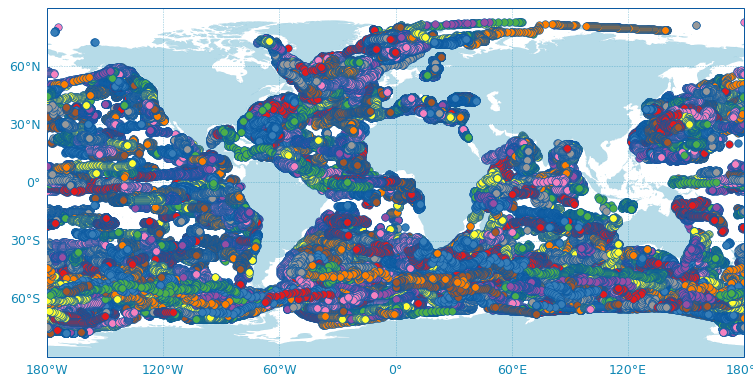

In [15]:
# import cartopy.crs as ccrs
# import cartopy
scatter_map(dfs_unique, traj=False, set_global=False, legend=False)

In [ ]:
"""
ref: https://argopy.readthedocs.io/en/latest/user-guide/fetching-argo-data/data_set.html#argo-dataset-available-in-argopy
the core Argo Mission: from floats that measure temperature, salinity, pressure down to 2000m,
the Deep Argo Mission: from floats that measure temperature, salinity, pressure down to 6000m,
and the BGC-Argo Mission: from floats that measure temperature, salinity, pressure and oxygen, pH, nitrate, chlorophyll, backscatter, irradiance down to 2000m.
FAQ: https://argo.ucsd.edu/data/data-faq
#### date range
# select max(date), min(date) from ...;
          max           |          min           
------------------------+------------------------
2024-05-23 09:57:30+08 | 2002-09-09 07:02:52+08
 
"""

In [57]:
def convert_types(row):
    """Convert all numpy types in the row to native Python types."""
    for key in row.index:
        if isinstance(row[key], (np.generic, np.ndarray)):
            row[key] = row[key].item()
    return row

def convert_types_dict(data):
    """Convert all numpy types in the data dictionary to native Python types."""
    for key, value in data.items():
        if isinstance(value, (np.generic, np.ndarray)):
            data[key] = value.item()
    return data



In [58]:
def expand_parameters(row):
    parameters = row['parameters'].split()
    modes = list(row['parameter_data_mode'])
    rows = {
        'parameter': parameters,
        'data_mode': [modes[i] for i in range(len(parameters)) if parameters[i] in parameters]
    }
    
    # Include all other columns
    for col in row.index.difference(['parameters', 'parameter_data_mode']):
        rows[col] = [row[col] for _ in parameters]
    
    return pd.DataFrame(rows)

In [59]:
# Apply the function and concatenate the results
dfo = pd.concat([expand_parameters(row) for index, row in dfs_unique.iterrows()]).reset_index(drop=True)

print(dfo) #1999024 (2024-05-25 09:21:29 date_update) -> 2083505 (20240813 11:04)


        parameter data_mode  cyc                date         date_update  \
0            PRES         A   84 2024-12-15 04:14:29 2024-12-15 06:02:59   
1            TEMP         A   84 2024-12-15 04:14:29 2024-12-15 06:02:59   
2            PSAL         A   84 2024-12-15 04:14:29 2024-12-15 06:02:59   
3            DOXY         R   84 2024-12-15 04:14:29 2024-12-15 06:02:59   
4          BBP700         A   84 2024-12-15 04:14:29 2024-12-15 06:02:59   
...           ...       ...  ...                 ...                 ...   
2174355      DOXY         R    1 2019-05-30 16:50:46 2022-06-13 22:24:07   
2174356      PRES         R    1 2019-05-28 16:57:00 2022-06-11 01:39:39   
2174357      TEMP         R    1 2019-05-28 16:57:00 2022-06-11 01:39:39   
2174358      PSAL         R    1 2019-05-28 16:57:00 2022-06-11 01:39:39   
2174359      DOXY         R    1 2019-05-28 16:57:00 2022-06-11 01:39:39   

                  institution  latitude  longitude ocean  \
0                   AOML, U

In [19]:
print(f"Date range in expanded_df: {dfo['date'].min()} to {dfo['date'].max()}")
print(dfo['wmo'].nunique())

Date range in expanded_df: 2002-09-08 23:02:52 to 2024-12-10 19:46:38
2370


In [ ]:
#ix = 2082334 - 1999024
#expanded_df.iloc[(ix-3):(ix+3)] 
# expanded_df['year'] = expanded_df['date'].dt.year
# db_year_counts = expanded_df['year'].value_counts().sort_index()
# print(db_year_counts)

In [20]:
df_wmo_counts = dfo['wmo'].value_counts().sort_index()

print(df_wmo_counts)

wmo
1900650    520
1900651    484
1900652    512
1900722    540
1900943    260
          ... 
7902199    198
7902200     84
7902203    592
7902215     80
7902223    266
Name: count, Length: 2370, dtype: int64


In [21]:
# Check for duplicates in the specified columns
duplicates = dfo.duplicated(subset=['wmo', 'cyc', 'parameter', 'date'], keep=False)

# Print out duplicates
print("Duplicates found:\n", dfo[duplicates].sort_values(['wmo', 'cyc', 'parameter']))


Duplicates found:
 Empty DataFrame
Columns: [parameter, data_mode, cyc, date, date_update, institution, latitude, longitude, ocean, profiler, wmo]
Index: []


In [22]:
test = dfo[(dfo['wmo'] == 1900722) & 
           (dfo['parameter'] == 'PRES')]
print(test) #2006-10-22 - 2010-07-15 11:19:48 (2022-06-28 08:36:49 update) first download

        parameter data_mode  cyc                date         date_update  \
2158113      PRES         D  135 2010-07-15 11:19:48 2022-06-28 08:36:49   
2158117      PRES         D  134 2010-07-05 06:41:50 2022-06-28 08:36:37   
2158121      PRES         D  133 2010-06-25 02:22:31 2022-06-28 08:36:24   
2158125      PRES         D  132 2010-06-15 01:08:33 2022-06-28 08:36:11   
2158129      PRES         D  131 2010-06-04 18:20:34 2022-06-28 08:35:59   
...           ...       ...  ...                 ...                 ...   
2158633      PRES         D    5 2006-12-01 18:33:00 2022-06-28 08:08:52   
2158637      PRES         D    4 2006-11-21 07:50:21 2022-06-28 08:08:39   
2158641      PRES         D    3 2006-11-11 10:12:22 2022-06-28 08:08:26   
2158645      PRES         D    2 2006-11-01 06:44:23 2022-06-28 08:08:13   
2158649      PRES         D    1 2006-10-22 02:16:24 2022-06-28 08:08:01   

        institution  latitude  longitude ocean profiler      wmo  
2158113   AOML, USA 

In [40]:
# dfo = expanded_df.drop('file', axis=1)
# dfo = dfo.drop('year', axis=1)
# dfo = dfo.apply(convert_types, axis=1)

In [23]:
df_w = dfs_unique.copy() #drop('file', axis=1)
df_w.sort_values(by='date', inplace=True)
# Convert dataframe types before using them in the session
df_w = df_w.apply(convert_types, axis=1)
print(df_w)

                      date  latitude  longitude ocean  \
11636  2002-09-08 23:02:52    22.882   -157.987     P   
11637  2002-09-19 12:00:42    22.910   -157.812     P   
11638  2002-09-30 01:30:01    22.887   -157.416     P   
11639  2002-10-10 14:18:32    22.803   -157.025     P   
11640  2002-10-21 03:05:10    22.736   -156.831     P   
...                    ...       ...        ...   ...   
259312 2024-12-10 17:08:00    32.886    157.240     P   
246577 2024-12-10 17:45:00    54.809     15.853     A   
128332 2024-12-10 18:14:02    55.203     19.309     A   
129244 2024-12-10 18:44:20    36.261     20.548     A   
153589 2024-12-10 19:46:38   -42.716     56.516     I   

                                               parameters parameter_data_mode  \
11636                                 PRES TEMP PSAL DOXY                DDDD   
11637                                 PRES TEMP PSAL DOXY                DDDD   
11638                                 PRES TEMP PSAL DOXY               

In [24]:
Base = declarative_base()
class ArgoWMO(Base):
    __tablename__ = WMOTABLE
    wmo = Column(Integer, primary_key=True)
    ocean = Column(TEXT)
    profiler = Column(TEXT)
    #profiler_code = Column(Integer)
    institution = Column(TEXT)
    #institution_code = Column(TEXT)
    # Relationships
    floats = relationship("ArgoFloat", back_populates="wmo_info")
    trajectories = relationship("ArgoTrajectory", back_populates="wmo_info")


In [25]:
class ArgoTrajectory(Base):
    __tablename__ = TRAJTABLE
    #wmo = Column(Integer, primary_key=True)  
    wmo = Column(Integer, ForeignKey(WMOTABLE + '.wmo'), primary_key=True)
    start_date = Column(TIMESTAMP(timezone=True))
    end_date = Column(TIMESTAMP(timezone=True))
    lon_max = Column(Float)
    lon_min = Column(Float)
    lat_max = Column(Float)
    lat_min = Column(Float)
    parameters = Column(TEXT)  # space-separated list of unique parameters
    data_modes = Column(TEXT)  # space-separated list of unique data modes
    geojson = Column(JSONB)  # storing GeoJSON as JSONB for better performance
    geom = Column(Geometry(geometry_type='LINESTRING', srid=4326))  # storing trajectory as a PostGIS geometry
    # Relationship
    wmo_info = relationship("ArgoWMO", back_populates="trajectories")
    
# Example to create and bind engine (adjust connection string as needed)


In [71]:
# Base.metadata.create_all(engine)

In [26]:
#Base = declarative_base()
#print(Base)
# Define a model for your data
class ArgoFloat(Base):
    __tablename__ = ARGOTABLE  # Update the table name to match your actual table
    date = Column(TIMESTAMP(timezone=True), nullable=False, primary_key=True)
    latitude = Column(Float, nullable=False)
    longitude = Column(Float, nullable=False)
    ocean = Column(TEXT)
    profiler = Column(TEXT)
    #profiler_code = Column(Integer)
    institution = Column(TEXT)
    #institution_code = Column(TEXT)
    date_update = Column(TIMESTAMP(timezone=True))
    wmo = Column(Integer, ForeignKey(WMOTABLE + '.wmo'))
    cyc = Column(Integer, nullable=False, primary_key=True)
    parameter = Column(TEXT, nullable=False, primary_key=True)
    data_mode = Column(TEXT, nullable=False)
    geom = Column(Geometry(geometry_type='POINT', srid=4326))
    update_timestamp = Column(TIMESTAMP(timezone=True), nullable=False, server_default=func.now(), onupdate=func.now())
    
    __table_args__ = (
        Index('argofloats_date_idx', 'date'),
        Index('argofloats_wmo_cyc_parameter_date_key', 'wmo', 'cyc', 'parameter', 'date', unique=True),
        Index('argofloats_wmo_cyc_parameter_date_idx', 'wmo', 'cyc', 'parameter', 'date'),
        Index('argofloats_date_parameter_idx', 'date', 'parameter'),
        Index('argofloats_date_data_mode_idx', 'date', 'data_mode'),
        Index('argofloats_geom_index', 'geom', postgresql_using='gist')
    )
    # Relationship
    wmo_info = relationship("ArgoWMO", back_populates="floats")

In [58]:
#floats = relationship("ArgoFloat", back_populates="wmo_info", primaryjoin="ArgoWMO.wmo == ArgoFloat.wmo")
#trajectories = relationship("ArgoTrajectory", primaryjoin="ArgoWMO.wmo==ArgoTrajectory.wmo", back_populates="wmo_info")
#floats

<_RelationshipDeclared at 0x7f7c1e335630; no key>

In [108]:
# Use Inspector to check if the table already exists
# Note create_all(self, bind=None, tables=None, checkfirst=True), and according to doc:
# Defaults to True, don't issue CREATEs for tables already present in the target database.
# inspector = inspect(engine)
# if not inspector.has_table(ARGOTABLE):  # Replace "argo_floats" with your table name
Base.metadata.create_all(engine)
print("Create table: ", Base)
# else:
# Table already exists, maybe print a message or perform other operations
# print("Table already exists. Skipping creation.", Base)
    

Create table:  <class 'sqlalchemy.orm.decl_api.Base'>


In [27]:
ocean_full_names = {
    'A': 'Atlantic Ocean Area',
    'I': 'Indian Ocean Area',
    'P': 'Pacific Ocean Area'
}

In [28]:
def create_geojson_line(group):
    # Ensure there are at least two points
    if len(group) < 2:
        return None  # or handle it some other way that fits your application's logic
    
    points = [geojson.Point((lon, lat)) for lon, lat in zip(group['longitude'], group['latitude'])]
    properties = {
        'wmo': int(group['wmo'].iloc[0]),
        'timestamps': group['date'].apply(lambda x: x.isoformat()).tolist()
    }
    line = geojson.LineString([(point.coordinates[0], point.coordinates[1]) for point in points])
    feature = geojson.Feature(geometry=line, properties=properties)
    return geojson.dumps(feature)

In [73]:
# Write WMOTABLE and TRAJTALE table
Session = sessionmaker(bind=engine)
session = Session()

for wmo, group in df_w.groupby('wmo'):
    ocean_area = ocean_full_names.get(group['ocean'].iloc[0], '') #'' means unspecified/unknown
    argo_wmo = ArgoWMO(
        wmo=wmo,
        ocean=ocean_area,
        profiler=group['profiler'].iloc[0],
        #profiler_code=int(group['profiler_code'].iloc[0]),
        institution=group['institution'].iloc[0],
        #institution_code=group['institution_code'].iloc[0]
    )
    session.add(argo_wmo)
    
    # Create trajectory data
    geojson_string = create_geojson_line(group)
    if geojson_string:
        line_geom = from_shape(LineString(list(zip(group['longitude'], group['latitude']))), srid=4326)
    else:
        line_geom = None  # Or some other default handling
    argo_trajectory = ArgoTrajectory(
        wmo=wmo,
        start_date=group['date'].min(),
        end_date=group['date'].max(),
        lon_max=float(group['longitude'].max()),
        lon_min=float(group['longitude'].min()),
        lat_max=float(group['latitude'].max()),
        lat_min=float(group['latitude'].min()),
        parameters=' '.join(set(' '.join(group['parameters']).split())),
        data_modes=' '.join(sorted(set(group['parameter_data_mode'].iloc[0]))),
        geojson=geojson_string,
        geom=line_geom
    )
    session.add(argo_trajectory)

session.commit()
session.close()

In [113]:
# Write ARGOTALE table
# Using bulk operations to reduce the number of individual transactions
Session = scoped_session(sessionmaker(bind=engine))

for index, row in dfo.iterrows():
    # Prepare the dictionary including the geom transformation
    data = row.to_dict()
    data['geom'] = WKTElement(f'POINT({row["longitude"]} {row["latitude"]})', srid=4326)

    # Create insert statement for the ArgoFloat data
    stmt = insert(ArgoFloat).values(**data)
    # Define the ON CONFLICT DO UPDATE behavior
    do_update_stmt = stmt.on_conflict_do_update(
        constraint='_wmo_cyc_parameter_date_uc',
        set_={k: v for k, v in data.items() if k != 'id'}
    )
    # Execute the statement
    Session.execute(do_update_stmt)

# Commit changes and close the session
Session.commit()
Session.close()

In [47]:
# Step 2: Insert new data with a new timestamp
current_timestamp = datetime.now(timezone.utc)
print(current_timestamp)

2024-08-22 04:01:02.959397+00:00


In [50]:
Session = sessionmaker(bind=engine)
session = Session()

def update_database(dfo, df_w):
    for index, row in dfo.iterrows():
        # Prepare the data dictionary including the geom transformation
        data = row.to_dict()
        data['geom'] = WKTElement(f'POINT({row["longitude"]} {row["latitude"]})', srid=4326)
        data['update_timestamp'] = current_timestamp

        # Convert NumPy types to Python types
        data = convert_types_dict(data)
        
        # Check if the record exists
        existing_record = session.query(ArgoFloat).filter(
            ArgoFloat.wmo == row['wmo'],
            ArgoFloat.cyc == row['cyc'],
            ArgoFloat.parameter == row['parameter'],
            ArgoFloat.date == row['date']
        ).first()

        if existing_record:
            # Update the record if data_update is more recent
            # if row['data_update'] > existing_record.data_update:
            stmt = update(ArgoFloat).where(
                ArgoFloat.wmo == row['wmo'],
                ArgoFloat.cyc == row['cyc'],
                ArgoFloat.parameter == row['parameter'],
                ArgoFloat.date == row['date']
            ).values(**data)
            session.execute(stmt)
        else:
            # Insert the new record
            stmt = insert(ArgoFloat).values(**data)
            session.execute(stmt)

    session.commit()

    for wmo, group in df_w.groupby('wmo'):
        ocean_area = ocean_full_names.get(group['ocean'].iloc[0], '')  # '' means unspecified/unknown
        # Check if the WMO exists in the ArgoWMO table
        existing_wmo = session.query(ArgoWMO).filter(ArgoWMO.wmo == wmo).first()

        if not existing_wmo:
            # Insert new WMO record
            argo_wmo = ArgoWMO(
                wmo=wmo,
                ocean=ocean_area,
                profiler=group['profiler'].iloc[0],
                institution=group['institution'].iloc[0]
            )
            session.add(argo_wmo)
        
        # Update or insert into ArgoTrajectory
        geojson_string = create_geojson_line(group)
        if geojson_string:
            line_geom = from_shape(LineString(list(zip(group['longitude'], group['latitude']))), srid=4326)
        else:
            line_geom = None  # Or some other default handling

        existing_trajectory = session.query(ArgoTrajectory).filter(ArgoTrajectory.wmo == wmo).first()
        if existing_trajectory:
            stmt = update(ArgoTrajectory).where(
                ArgoTrajectory.wmo == wmo
            ).values(
                start_date=group['date'].min(),
                end_date=group['date'].max(),
                # cause InvalidSchemaName error: schema "np" does not exist (lon_max=np.float64...)
                lon_max=float(group['longitude'].max()), 
                lon_min=float(group['longitude'].min()),
                lat_max=float(group['latitude'].max()),
                lat_min=float(group['latitude'].min()),
                parameters=' '.join(set(' '.join(group['parameters']).split())),
                data_modes=' '.join(sorted(set(group['parameter_data_mode'].iloc[0]))),
                geojson=geojson_string,
                geom=line_geom
            )
            session.execute(stmt)
        else:
            argo_trajectory = ArgoTrajectory(
                wmo=wmo,
                start_date=group['date'].min(),
                end_date=group['date'].max(),
                lon_max=float(group['longitude'].max()), 
                lon_min=float(group['longitude'].min()),
                lat_max=float(group['latitude'].max()),
                lat_min=float(group['latitude'].min()),
                parameters=' '.join(set(' '.join(group['parameters']).split())),
                data_modes=' '.join(sorted(set(group['parameter_data_mode'].iloc[0]))),
                geojson=geojson_string,
                geom=line_geom
            )
            session.add(argo_trajectory)

    # Remove old records that were not updated in this cycle
    stmt_delete = delete(ArgoFloat).where(ArgoFloat.update_timestamp < current_timestamp)
    session.execute(stmt_delete)
    session.commit()

    session.close()

In [51]:
# Example usage:
update_database(dfo, df_w)

In [30]:
# Update code (Not yet...)
# Update the past 7 days data into database
today = datetime.now(timezone.utc)
data_since_last_7days = today - timedelta(days=7)
data_since_last_download = datetime(2024, 5, 24, 16, 0, 0, tzinfo=pytz.timezone("UTC")) 

# Define the region box [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
# Convert datetime objects to strings in a format that Pandas can understand
today_str = today.strftime('%Y-%m-%dT%H:%M:%SZ')  # ISO 8601 format
data_since_last_7days_str = data_since_last_7days.strftime('%Y-%m-%dT%H:%M:%SZ')
data_since_last_dload_str = data_since_last_download.strftime('%Y-%m-%dT%H:%M:%SZ')

# Define the region box
BOX = [-180, 180, -90, 90, 0, 2000, data_since_last_dload_str, today_str]
print("Time duration: ", data_since_last_dload_str, today_str)


Time duration:  2024-05-24T16:00:00Z 2024-08-12T08:07:19Z


In [31]:
# Fetch data
f = DataFetcher(ds='bgc', mode='expert', src='erddap', params='all',
            parallel=True, progress=True, cache=True,
            chunks_maxsize={'time': 10})
f = f.region(BOX).load()
idx = f.index


Final post-processing of the merged dataset () ...


/home/bioer/.pyenv/versions/3.11.3/envs/py311/lib/python3.11/site-packages/argopy/xarray.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self._dims = list(xarray_obj.dims.keys())


In [32]:
df = idx
print(df)

                                        file                date  latitude  \
0     aoml/1902304/profiles/SR1902304_164.nc 2024-05-30 20:25:58    57.462   
1     aoml/1902304/profiles/SR1902304_165.nc 2024-06-09 20:27:49    57.992   
2     aoml/1902304/profiles/SR1902304_166.nc 2024-06-19 20:24:35    58.658   
3     aoml/1902304/profiles/SR1902304_167.nc 2024-06-29 20:22:50    58.914   
4     aoml/1902304/profiles/SR1902304_168.nc 2024-07-09 20:21:03    59.061   
...                                      ...                 ...       ...   
5626  meds/4902688/profiles/SR4902688_028.nc 2024-07-14 15:39:00    58.088   
5627  meds/4902688/profiles/SR4902688_029.nc 2024-07-20 15:35:00    58.088   
5628  meds/4902688/profiles/SR4902688_030.nc 2024-07-26 15:35:00    58.092   
5629  meds/4902688/profiles/SR4902688_031.nc 2024-08-01 15:37:00    58.095   
5630  meds/4902688/profiles/SR4902688_032.nc 2024-08-07 15:35:00    57.834   

      longitude ocean  profiler_code institution_code  \
0     

In [34]:
print(df.columns.values.tolist())
df['date'].agg(['min', 'max'])
df['date_update'].agg(['min', 'max'])

['file', 'date', 'latitude', 'longitude', 'ocean', 'profiler_code', 'institution_code', 'parameters', 'parameter_data_mode', 'date_update', 'wmo', 'cyc', 'institution', 'profiler']


min   2024-05-24 22:12:16
max   2024-08-12 06:17:00
Name: date_update, dtype: datetime64[ns]

In [35]:
dfx = df.dropna(subset = ['longitude', 'latitude', 'date', 'parameters', 'parameter_data_mode'])
print(len(dfx))

5631


In [40]:
dfx_sorted = dfx.drop("file", axis=1).sort_values(by='date_update', ascending=False)
dfx_unique = dfx_sorted.drop_duplicates(subset=['wmo', 'cyc', 'parameters', 'date'], keep='first')
print(dfx_unique.head())
print(len(dfx_unique))

                    date  latitude  longitude ocean  profiler_code  \
4385 2024-08-12 03:37:26   -41.513     63.142     I            846   
2877 2024-08-12 03:00:00    69.175      5.416     A            838   
5021 2024-08-12 02:59:00    22.684    130.732     P            870   
2291 2024-08-11 22:24:00    -2.460    -18.744     A            836   
2509 2024-08-11 21:49:18    20.031   -156.540     P            834   

     institution_code                                         parameters  \
4385               IF  PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...   
2877               IF                                PRES TEMP PSAL DOXY   
5021               HZ                                PRES TEMP PSAL DOXY   
2291               BO  PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...   
2509               IF  PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...   

     parameter_data_mode         date_update      wmo  cyc  \
4385         AAAAAAARRRR 2024-08-12 06:17:00  6904118  154  

In [41]:
# Check again for duplicates to ensure the process was successful
assert not dfx_unique.duplicated(subset=['wmo', 'cyc', 'parameters', 'date']).any(), "Duplicates remain after processing!"


In [42]:
# Apply the function and concatenate the results
expanded_dfx = pd.concat([expand_parameters(row) for index, row in dfx_unique.iterrows()]).reset_index(drop=True)

print(expanded_dfx) 

      parameter data_mode  cyc                date         date_update  \
0          PRES         A  154 2024-08-12 03:37:26 2024-08-12 06:17:00   
1          TEMP         A  154 2024-08-12 03:37:26 2024-08-12 06:17:00   
2          PSAL         A  154 2024-08-12 03:37:26 2024-08-12 06:17:00   
3          DOXY         A  154 2024-08-12 03:37:26 2024-08-12 06:17:00   
4          CHLA         A  154 2024-08-12 03:37:26 2024-08-12 06:17:00   
...         ...       ...  ...                 ...                 ...   
46082   NITRATE         R   64 2024-05-24 23:04:47 2024-05-25 01:08:03   
46083      PRES         R  224 2024-05-24 19:15:30 2024-05-24 22:12:16   
46084      TEMP         R  224 2024-05-24 19:15:30 2024-05-24 22:12:16   
46085      PSAL         R  224 2024-05-24 19:15:30 2024-05-24 22:12:16   
46086      DOXY         A  224 2024-05-24 19:15:30 2024-05-24 22:12:16   

           institution institution_code  latitude  longitude ocean profiler  \
0      Ifremer, France          

In [43]:
# Check for duplicates in the specified columns
duplicates = expanded_dfx.duplicated(subset=['wmo', 'cyc', 'parameter', 'date'], keep=False)

# Print out duplicates
print("Duplicates found:\n", expanded_dfx[duplicates].sort_values(['wmo', 'cyc', 'parameter']))


Duplicates found:
 Empty DataFrame
Columns: [parameter, data_mode, cyc, date, date_update, institution, institution_code, latitude, longitude, ocean, profiler, profiler_code, wmo]
Index: []


In [44]:
df_wx = dfx_unique
df_wx.sort_values(by='date', inplace=True)
print(df_wx)

                    date  latitude  longitude ocean  profiler_code  \
256  2024-05-24 17:17:35   -49.447    130.058     I            846   
2557 2024-05-24 17:34:37    67.496     -0.408     A            834   
1309 2024-05-24 17:47:45   -12.505   -116.762     P            846   
2410 2024-05-24 18:03:06    55.307     19.273     A            834   
2412 2024-05-24 18:32:38    55.307     19.273     A            834   
...                  ...       ...        ...   ...            ...   
2509 2024-08-11 21:49:18    20.031   -156.540     P            834   
2291 2024-08-11 22:24:00    -2.460    -18.744     A            836   
5021 2024-08-12 02:59:00    22.684    130.732     P            870   
2877 2024-08-12 03:00:00    69.175      5.416     A            838   
4385 2024-08-12 03:37:26   -41.513     63.142     I            846   

     institution_code                                         parameters  \
256                AO  PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...   
2557   

In [ ]:
# Define your database connection
session_factory = sessionmaker(bind=engine)
Session = scoped_session(session_factory)

# Update or insert data into the database
for index, row in expanded_df.iterrows():
    try:
        # Check if the float already exists
        existing = Session.query(ArgoFloat).filter(
            and_(
                ArgoFloat.wmo == row['wmo'],
                ArgoFloat.cyc == row['cyc'],
                ArgoFloat.parameter == row['parameter'],
                ArgoFloat.date == row['date'],
            )
        ).one()
        # Update existing record
        for key, value in row.items():
            setattr(existing, key, value)
        existing.geom = WKTElement(f'POINT({row["longitude"]} {row["latitude"]})', srid=4326)
    except NoResultFound:
        # Create new record if not exists
        new_float = ArgoFloat(**row.to_dict())
        new_float.geom = WKTElement(f'POINT({row["longitude"]} {row["latitude"]})', srid=4326)
        Session.add(new_float)

# Commit the changes
Session.commit()
Session.close()        